# What do we have for dinner ?

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
plt.style.use('seaborn')

## Some Data

In [2]:
import os, zipfile
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        p = os.path.join(dirname, filename)
        with zipfile.ZipFile(p, 'r') as zip_ref:
            zip_ref.extract('.'.join(filename.split('.')[:-1]))
os.listdir()

['test.json',
 'train.json',
 '__notebook_source__.ipynb',
 'sample_submission.csv']

In [3]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')
train[:3]

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."


In [4]:
lists_of_ingredients = train.ingredients.values.ravel().tolist() + test.ingredients.values.ravel().tolist()

unique_ingredients = sorted(list(set(list(itertools.chain(*lists_of_ingredients)))))

unique_ingredients[:3],len(unique_ingredients)

(['(    oz.) tomato sauce',
  '(   oz.) tomato paste',
  '(10 oz.) frozen chopped spinach'],
 7137)

In [5]:
def format_ingredients(full_list,given_list):
    l = [0] * len(full_list)
    for x in given_list:
        l[full_list.index(x)] = 1
    return l

In [6]:
%%time
train[unique_ingredients] = pd.DataFrame(train.ingredients.apply(lambda x: format_ingredients(unique_ingredients,x)).tolist(),columns=unique_ingredients)
train.drop(['ingredients'],axis=1,inplace=True)

CPU times: user 4min 25s, sys: 18 s, total: 4min 43s
Wall time: 4min 44s


In [7]:
%%time
test[unique_ingredients] = pd.DataFrame(test.ingredients.apply(lambda x: format_ingredients(unique_ingredients,x)).tolist(),columns=unique_ingredients)
test.drop(['ingredients'],axis=1,inplace=True)

CPU times: user 1min 10s, sys: 1 s, total: 1min 11s
Wall time: 1min 11s


## Some Quick EDA

**Number of receipes by Cuisine**

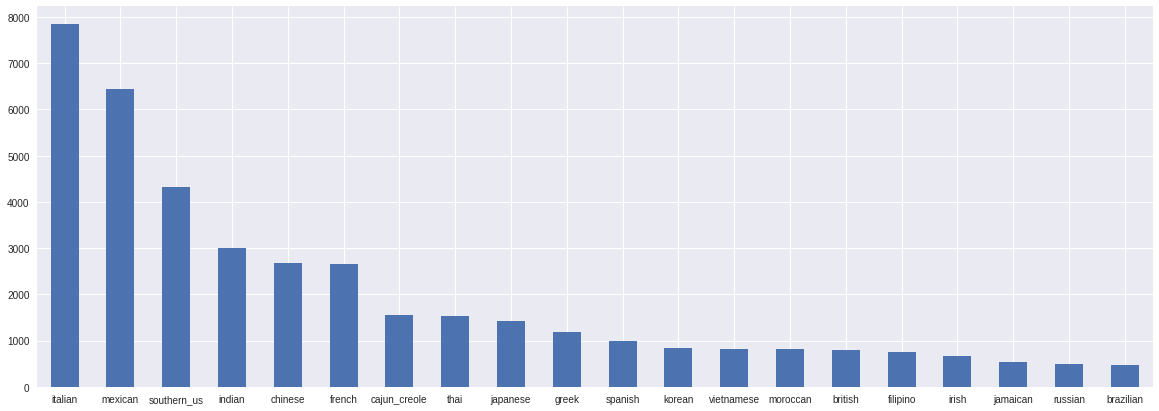

In [8]:
train.cuisine.value_counts().plot.bar(rot=0,figsize=(20,7));

**Top 15 most used Ingredients**

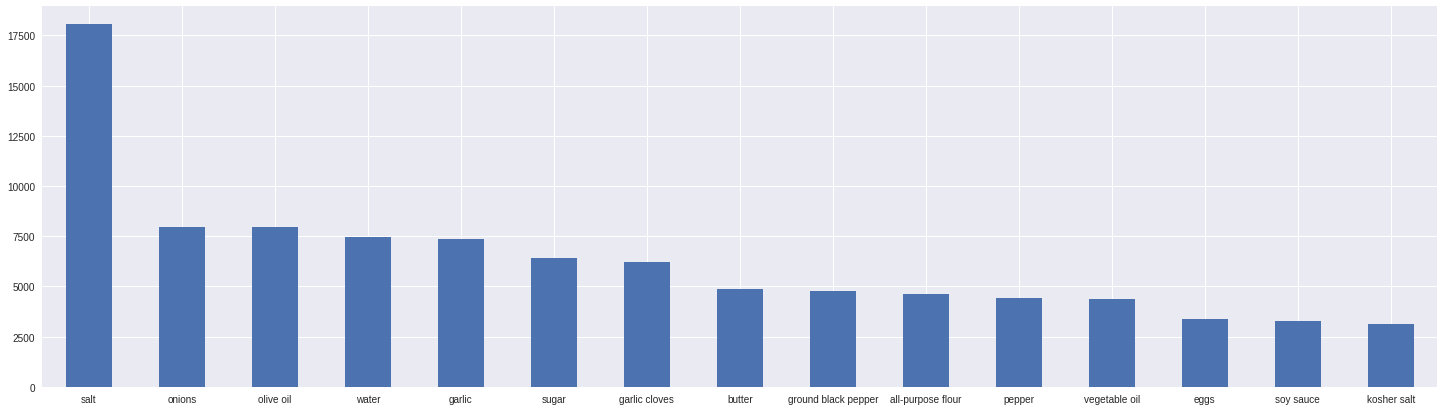

In [9]:
train.sum()[2:].sort_values(ascending=False)[:15].plot.bar(rot=0,figsize=(25,7));

## Modelling

In [10]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

**Split data into train/test**

In [11]:
train_,test_ = train_test_split(train,test_size=0.33,random_state=42,stratify=train.cuisine)

**Check proportions**

In [12]:
'train:',train_.cuisine.value_counts() / len(train_),'test:',test_.cuisine.value_counts() / len(test_)

('train:',
 italian         0.197050
 mexican         0.161851
 southern_us     0.108601
 indian          0.075503
 chinese         0.067210
 french          0.066534
 cajun_creole    0.038877
 thai            0.038690
 japanese        0.035763
 greek           0.029533
 spanish         0.024880
 korean          0.020865
 vietnamese      0.020752
 moroccan        0.020639
 british         0.020227
 filipino        0.018988
 irish           0.016774
 jamaican        0.013209
 russian         0.012309
 brazilian       0.011746
 Name: cuisine, dtype: float64,
 'test:',
 italian         0.197090
 mexican         0.161892
 southern_us     0.108639
 indian          0.075499
 chinese         0.067195
 french          0.066509
 cajun_creole    0.038854
 thai            0.038702
 japanese        0.035807
 greek           0.029560
 spanish         0.024836
 korean          0.020875
 vietnamese      0.020722
 moroccan        0.020646
 british         0.020189
 filipino        0.018970
 irish     

**Training**

In [13]:
import xgboost as xgb

In [14]:
%%time
xgc = xgb.XGBClassifier(objective='multi:softmax',num_class=train.cuisine.nunique())
xgc.fit(train_[train_.columns[2:]],train_['cuisine'])

CPU times: user 6h 49min 27s, sys: 27.7 s, total: 6h 49min 55s
Wall time: 1h 45min 36s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=20, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Results**

In [15]:
results = test_[['id','cuisine']].copy()
results['y_pred'] = xgc.predict(test_[test_.columns[2:]])

**Classification Report**

In [16]:
print(metrics.classification_report(results.cuisine,results.y_pred))

              precision    recall  f1-score   support

   brazilian       0.76      0.49      0.60       154
     british       0.62      0.35      0.45       265
cajun_creole       0.79      0.70      0.74       510
     chinese       0.77      0.84      0.81       882
    filipino       0.68      0.48      0.56       249
      french       0.59      0.56      0.57       873
       greek       0.78      0.63      0.70       388
      indian       0.86      0.86      0.86       991
       irish       0.62      0.43      0.51       220
     italian       0.70      0.89      0.79      2587
    jamaican       0.85      0.60      0.70       174
    japanese       0.82      0.64      0.72       470
      korean       0.83      0.69      0.75       274
     mexican       0.87      0.89      0.88      2125
    moroccan       0.78      0.70      0.74       271
     russian       0.61      0.35      0.45       161
 southern_us       0.66      0.75      0.70      1426
     spanish       0.68    

**Confusion Matrix**

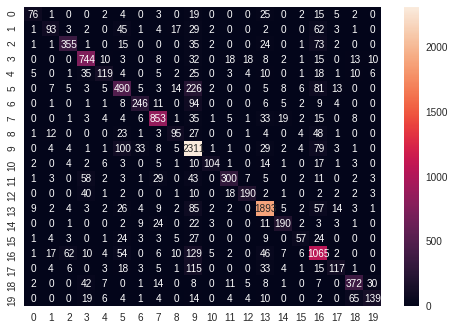

In [18]:
sns.heatmap(metrics.confusion_matrix(results.cuisine,results.y_pred),annot=True,fmt='d');

Usually I retrain using all train data before submission,

but since this appraoche takes ages, I will just use the model already trained on splitted data

In [21]:
%%time
sub = test[['id']].copy()
sub['cuisine'] = xgc.predict(test[test.columns[1:]])

CPU times: user 14.6 s, sys: 1.25 s, total: 15.9 s
Wall time: 7.25 s
